In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.linear_model import Ridge
import mlflow as ml
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_squared_error

In [2]:
ml.set_tracking_uri("sqlite:///mlflow.db")
ml.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/muhammad/zoomcamp-mlops/02-experiment_tracking/mlruns/1', creation_time=1742106226426, experiment_id='1', last_update_time=1742106226426, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [4]:
df = read_dataframe("../data/green_tripdata_2024-01.parquet")
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333


In [5]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.12641462014641

/tmp/ipykernel_7219/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_7219/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


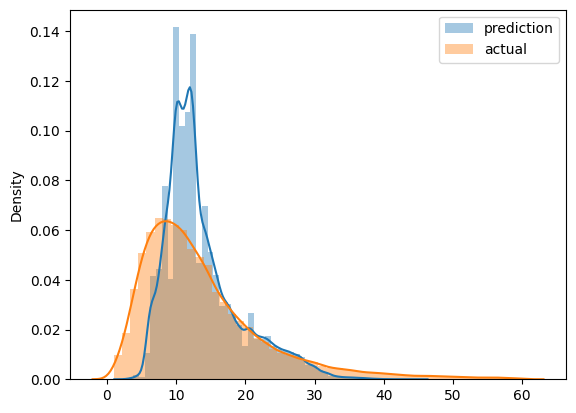

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
df_train = read_dataframe('../data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2024-02.parquet')

In [8]:
len(df_train), len(df_val)

(54373, 51497)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

### First way to save model:
- Download model from mlflow ui

In [15]:
with ml.start_run():
    
    ml.set_tag("developer", "umer")    
    ml.log_param("train-data-path", "../data/green_tripdata_2024-01.parquet")
    ml.log_param("val-data-path", "../data/green_tripdata_2024-02.parquet")
    
    alpha = 0.1
    ml.log_param("alpha", alpha)

    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    ml.log_metric("rmse", rmse)
    
    ml.log_artifact(local_path="./models/lin_reg.bin", artifact_path="models_pickle")

In [13]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
train = xgb.DMatrix(X_train, label=y_train)
val = xgb.DMatrix(X_val, label=y_val)

In [15]:
def objective(params):
    with ml.start_run():
        ml.set_tag("model", "xgboost")
        ml.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,  # Reduced further from 200 to 100
            evals=[(val, 'validation')],
            early_stopping_rounds=20,  # Reduced from 30 to 20
            verbose_eval=False  # Suppress long logs for speed
        )

        y_pred = booster.predict(val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))  # Compute RMSE manually
        ml.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [16]:
# Optimized search space for faster execution
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),  # Reduced from 4-20 to 3-10
    'learning_rate': hp.loguniform('learning_rate', -2.5, -0.5),  # Narrowed range for faster convergence
    'reg_alpha': hp.loguniform('reg_alpha', -4, -2),  # Reduced regularization range
    'reg_lambda': hp.loguniform('reg_lambda', -4, -2),  # Reduced range
    'min_child_weight': hp.loguniform('min_child_weight', 0, 1.5),  # Further reduced range
    'subsample': hp.uniform('subsample', 0.6, 1.0),  # Helps training speed by using a subset of data
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),  # Uses fewer features per tree
    'objective': 'reg:squarederror',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,  # Reduced from 30 to 20
    trials=Trials()
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [01:44<00:00,  5.23s/trial, best loss: 5.22046287012043] 


In [19]:
# Enable MLflow autologging (only once)
ml.xgboost.autolog()

params = {
    "colsample_bytree": 0.9508953539435933,
    "learning_rate": 0.16951504072104825,
    "max_depth": 3,
    "min_child_weight": 1.8867047253142906,
    "reg_alpha": 0.12523791664496034,
    "reg_lambda": 0.08420764704582243,
    "seed": 42,
    "subsample": 0.6728802226837359
}

# Start an MLflow run explicitly
booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=100,  # Reduced further from 200 to 100
        evals=[(val, 'validation')],
        early_stopping_rounds=20,  # Reduced from 30 to 20
        verbose_eval=False  # Suppress long logs for speed
    )

2025/03/16 12:42:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '569c0db3747e4b81bb7eb2d9317cf375', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


2025/03/16 12:42:55 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/03/16 12:42:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/venvs/env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:42:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/03/16 12:43:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
# Make predictions
y_pred = booster.predict(val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Log RMSE manually
ml.log_metric("rmse", rmse)

# Save the model in JSON format (to avoid UBJSON warnings)
booster.save_model("model.json")
ml.xgboost.log_model(booster, "xgboost_model")

print(f"RMSE: {rmse}")  # Print RMSE for reference

### Second Way

In [19]:
with ml.start_run():

    params = {
        "colsample_bytree": 0.9508953539435933,
        "learning_rate": 0.16951504072104825,
        "max_depth": 3,
        "min_child_weight": 1.8867047253142906,
        "reg_alpha": 0.12523791664496034,
        "reg_lambda": 0.08420764704582243,
        "seed": 42,
        "subsample": 0.6728802226837359
    }

    ml.log_params(params)
    
    train = xgb.DMatrix(X_train, label=y_train)
    val = xgb.DMatrix(X_val, label=y_val)
    
    # Start an MLflow run explicitly
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,  # Reduced further from 200 to 100
            evals=[(val, 'validation')],
            early_stopping_rounds=20,  # Reduced from 30 to 20
            verbose_eval=False  # Suppress long logs for speed
        )
    
    y_pred = booster.predict(val)
    rmse = mean_squared_error(y_val, y_pred)
    ml.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f:
        pickle.dump(dv, f)
    
    ml.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    ml.xgboost.log_model(booster, artifact_path="models_mlflow")

/opt/venvs/env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:04:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/16 20:04:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [20]:
logged_model = 'runs:/93324c0e14a140d89926b076ea587273/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = ml.pyfunc.load_model(logged_model)

In [21]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 93324c0e14a140d89926b076ea587273

In [23]:
xgboost_model = ml.xgboost.load_model(logged_model)
xgboost_model

In [24]:
y_pred = xgboost_model.predict(val)
y_pred[:10]

array([17.53736  , 27.593481 ,  7.5640326,  9.387701 ,  4.9878983,
        4.9878983,  9.387701 , 24.418892 , 21.717962 ,  6.3048067],
      dtype=float32)